In [1]:
import torch
from torch import nn
import torch.nn.functional as F
from torch.optim import Adam, SGD
from torch.utils.data import DataLoader, Dataset
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.nn.utils import clip_grad_norm_
import pandas as pd
import numpy as np
from sklearn.metrics import classification_report, f1_score, accuracy_score
from tqdm import tqdm_notebook as tqdm
import torchnet as tnt
#from keras.preprocessing.sequence import pad_sequences
import warnings
warnings.filterwarnings('ignore')
from utils import *
import matplotlib.pyplot as plt
%matplotlib inline 
from deep_models import *

Using CNTK backend


using gpu


In [2]:
def train_model(model, data_iter, loss_fun, opt):
    model.train()
    meter = tnt.meter.AverageValueMeter()
    meter.reset()
    y_pred = []
    y_true = []
    for headlines, bodies, tfidf_sim, labels in tqdm(data_iter):
        opt.zero_grad()
        headlines = torch.from_numpy(headlines).cuda().long()
        bodies = torch.from_numpy(bodies).cuda().long()
        tfidf_sim = torch.from_numpy(tfidf_sim).cuda().float()
        y_true.extend(labels)
        labels = torch.from_numpy(labels).cuda().long()
        out, _, _ = model(headlines, bodies, tfidf_sim)
        _, index = torch.max(out, dim=1)
        y_pred.extend(index.cpu().data.numpy())
        loss = loss_fun(out, labels)
        loss.backward()
        clip_grad_norm_(model.parameters(), 1.0)
        opt.step()
        meter.add(loss.item())
    return meter.value()[0]

def val_model(model, data_iter, loss_fun):
    model.eval()
    meter = tnt.meter.AverageValueMeter()
    meter.reset()
    y_pred = []
    y_true = []
    with torch.no_grad():
        for headlines, bodies, tfidf_sim, labels in tqdm(data_iter):
            headlines = torch.from_numpy(headlines).cuda().long()
            bodies = torch.from_numpy(bodies).cuda().long()
            tfidf_sim = torch.from_numpy(tfidf_sim).cuda().float()
            y_true.extend(labels)
            labels = torch.from_numpy(labels).cuda().long()
            out, _, _ = model(headlines, bodies, tfidf_sim)
            _, index = torch.max(out, dim=1)
            y_pred.extend(index.cpu().data.numpy())
            loss = loss_fun(out, labels)
            meter.add(loss.item())

    model.train()
    return meter.value()[0]

def test_model(model, data_iter):
    model.eval()
    y_pred = []
    y_true = []
    with torch.no_grad():
        for headlines, bodies, tfidf_sim, labels in tqdm(data_iter):
            headlines = torch.from_numpy(headlines).cuda().long()
            bodies = torch.from_numpy(bodies).cuda().long()
            tfidf_sim = torch.from_numpy(tfidf_sim).cuda().float()
            y_true.extend(labels)
            labels = torch.from_numpy(labels).cuda().long()
            out, _, _ = model(headlines, bodies, tfidf_sim)
            _, index = torch.max(out, dim=1)
            y_pred.extend(index.cpu().data.numpy())

    model.train()
    print('classification report:')
    print('accuracy: %.3f' % accuracy_score(y_true, y_pred))
    print(classification_report(y_true, y_pred))
    print('macro f1: %.3f' % f1_score(y_true, y_pred, average='macro'))
    print('score: %.3f' % (get_score(y_true, y_pred) / get_score(y_true, y_true)))
    
def my_plot(data):
    plt.plot(data['train'])
    plt.plot(data['val'])
    plt.legend(['train', 'val'])
    plt.show()
    print('best epoch num: %s loss: %.3f' % (np.argmin(data['val']) +1, min(data['val'])))
    
def test_get_batch(data_iter):
    for headlines, bodies, tfidf, labels in tqdm(data_iter):
        #print(headlines.shape)
        print(bodies.shape)
        #print(labels.shape)
#test_get_batch(get_batch_v2('./tmp/val_ids.pkl', './tmp/tfidf_sim.pkl', 'val', batch_size=64, max_len_b=100))

In [3]:
class EsimPlus(nn.Module):
        """docstring for EsimPlus"""
        def __init__(self, pretrained, hid_size=100):
            super(EsimPlus, self).__init__()
            vocab_size, emb_size = pretrained.shape
            self.embedding = nn.Embedding.from_pretrained(torch.from_numpy(pretrained).float())
            self.gru_enc1 = nn.LSTM(input_size=emb_size, hidden_size=hid_size, 
                batch_first=True, bidirectional=True)
            self.gru_comp1 = nn.LSTM(input_size=hid_size * 8, hidden_size=hid_size, 
                batch_first=True, bidirectional=True)

            self.fc1 = nn.Linear(hid_size * 8, hid_size)
            self.fc2 = nn.Linear(hid_size + 1, hid_size + 1)
            self.last_layer = nn.Linear(hid_size + 1, 4)

        def forward(self, x1, x2, tfidf_sim):
            # to shape B * T1 * T2
            x1_mask = x1.eq(0).unsqueeze(2)
            x2_mask = x2.eq(0).unsqueeze(1)
            
            x1 = self.embedding(x1)
            x2 = self.embedding(x2)

            x1, h1 = self.gru_enc1(x1)
            x2, h2 = self.gru_enc1(x2)

            # attention
            x2_t = torch.transpose(x2, 1, 2)
            attention = torch.bmm(x1, x2_t)
            
            attention.masked_fill_(x1_mask, 1e-6).masked_fill_(x2_mask, 1e-6)
            w1_attn = F.softmax(attention, dim=2)
            w2_attn = F.softmax(attention, dim=1)
            w2_attn_t = torch.transpose(w2_attn, 1, 2)

            x1_attn = torch.matmul(w1_attn, x2)
            x2_attn = torch.matmul(w2_attn_t, x1)

            x1_sub = x1 - x1_attn
            x2_sub = x2 - x2_attn

            x1_mul = x1 * x1_attn
            x2_mul = x2 * x2_attn

            x1_concat = torch.cat((x1, x1_attn, x1_sub, x1_mul), 2)
            x2_concat = torch.cat((x2, x2_attn, x2_sub, x2_mul), 2)

            x1_concat, _ = self.gru_comp1(x1_concat)
            x2_concat, _ = self.gru_comp1(x2_concat)

            x1_max_pooling, _ = torch.max(x1_concat, 1)
            x2_max_pooling, _ = torch.max(x2_concat, 1)
            x1_avg_pooling = torch.mean(x1_concat, 1)
            x2_avg_pooling = torch.mean(x2_concat, 1)

            x = torch.cat((x1_max_pooling, x1_avg_pooling, x2_max_pooling, x2_avg_pooling), 1)
            x = F.relu(self.fc1(x))
            x = F.dropout(x, p=0.5, training=self.training)
            
            x = torch.cat((x, tfidf_sim), dim=1)
            x = F.relu(self.fc2(x))
            x = F.dropout(x, p=0.5, training=self.training)
            x = F.softmax(self.last_layer(x))
            return x, w1_attn, w2_attn

In [4]:
pretrained_file_name = './tmp/pretrained.pkl'
train_filename = './tmp/train_ids.pkl'
val_filename = './tmp/val_ids.pkl'
test_filename = './tmp/test_ids.pkl'
tfidf_filename = './tmp/tfidf_sim.pkl'
vecs = pickle.load(open(pretrained_file_name, 'rb'))

EsimPlus(
  (embedding): Embedding(399670, 100)
  (gru_enc1): LSTM(100, 100, batch_first=True, bidirectional=True)
  (gru_comp1): LSTM(800, 100, batch_first=True, bidirectional=True)
  (fc1): Linear(in_features=800, out_features=100, bias=True)
  (fc2): Linear(in_features=101, out_features=101, bias=True)
  (last_layer): Linear(in_features=101, out_features=4, bias=True)
)


Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"


Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"


Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"


Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"


Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"


Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"


Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"


Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"


Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"


Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"


Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"


Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"


Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"


Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"


Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"


Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"



Epoch     7: reducing learning rate of group 0 to 1.0000e-04.


Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"


Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"



Epoch     8: reducing learning rate of group 0 to 1.0000e-05.


Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"


Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"



Epoch     9: reducing learning rate of group 0 to 1.0000e-06.


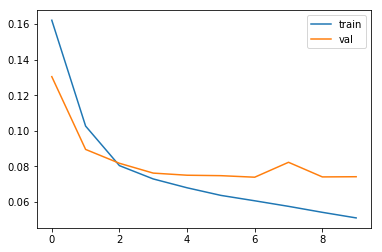

best epoch num: 7 loss: 0.074


In [5]:
torch.manual_seed(42)
torch.backends.cudnn.deterministic = True
np.random.seed(42)
model_name = 'Esim_plus'
if model_name == 'EmbeddingBag':
    model = EmbeddingBag(vecs).cuda()
elif model_name == 'CE':
    model = CE(vecs).cuda()
elif model_name == 'IE':
    model = IE(vecs).cuda()
elif model_name == 'Esim_plus':
    model = EsimPlus(vecs).cuda()
elif model_name == 'Dattn':
    model = Dattn(vecs).cuda()
elif model_name == 'Declare':
    model = Declare(vecs).cuda()
    
print(model)
opt = Adam(model.parameters(), lr=1e-3, weight_decay=1e-8)
weight = torch.Tensor([3, 3, 3, 1])
#loss_fun = nn.CrossEntropyLoss(weight)
scheduler = ReduceLROnPlateau(opt, 'min', factor=0.1, patience=0, verbose=True)
loss_fun = FocalLoss(gamma=5)
loss_fun.cuda()
epochs = 10
history = {'train':[], 'val': []}
min_loss = 100.1

for epoch in range(epochs):
    #print(f"epoch: {epoch + 1}/{epochs}")
    train_loss = train_model(model, get_batch_v2(train_filename, tfidf_filename, 'train', batch_size=64, max_len_b=100), loss_fun, opt)
    val_loss = val_model(model, get_batch_v2(val_filename, tfidf_filename, 'val', batch_size=64, max_len_b=100), loss_fun)
    if val_loss < min_loss:
        torch.save(model.state_dict(), './models/%s_%s_%.3f' % (model_name, epoch + 1, val_loss))
        
    scheduler.step(val_loss)
    history['train'].append(train_loss)
    history['val'].append(val_loss)
    
my_plot(history)

In [ ]:
model_name = 'Esim'
if model_name == 'EmbeddingBag':
    model = EmbeddingBag(vecs).cuda()
elif model_name == 'CE':
    model = CE(vecs).cuda()
elif model_name == 'IE':
    model = IE(vecs).cuda()
elif model_name == 'Esim':
    model = Esim(vecs).cuda()
elif model_name == 'Dattn':
    model = Dattn(vecs).cuda()
elif model_name == 'Declare':
    model = Declare(vecs).cuda()

model.load_state_dict(torch.load('./models/Esim_10_0.069'))
test_model(model, get_batch(val_filename, batch_size=64, max_len_b=200))
print('*' * 50)
test_model(model, get_batch(test_filename, batch_size=64, max_len_b=200))